## Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

In [2]:
import json
import cv2
import json
import os
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import h5py

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from keras.optimizers import SGD
from keras import backend as K
from keras.saving import load_model

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score
from sklearn.model_selection import train_test_split

drive_path = "/content/drive/MyDrive/"
drive_dir = "Graduation Project" # @param {type:"string"}
drive_path += drive_dir

## Download datasets

In [ ]:
# Dataset #1
!wget 'https://box.vicos.si/skokec/villard/JPEGImages.tar.bz2'
!tar xjvf JPEGImages.tar.bz2
!mv JPEGImages "$drive_path"
drive.flush_and_unmount()
drive.mount('/content/drive')

# Dataset #2
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="MONDheoK2uXUHRlWTKXh")
project = rf.workspace("midstem").project("road-signs-vanga")
version = project.version(16)
dataset = version.download("coco")
!unzip 'Road-signs-16/roboflow.zip'

# Save to drive
!mkdir "$drive_path/road-signs-16"
!mv train "$drive_path/road-signs-16"
!mv test "$drive_path/road-signs-16"
!mv valid "$drive_path/road-signs-16"

drive.flush_and_unmount()
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.2 MB/s eta 0:00:00
ERROR: Operation cancelled by user


ModuleNotFoundError: No module named 'roboflow'

## Download annotations for dataset #1



In [ ]:
# images that are too small are set to be ignored in these annotations
!wget 'https://box.vicos.si/skokec/villard/DFG-tsd-aug-annot-json-with-difficult-samples.zip'
!unzip DFG-tsd-aug-annot-json-with-difficult-samples.zip
!mv train-difficult.json "$drive_path"

## Utils

In [ ]:
'''
Code to convert image to greyscale and resize
'''
def preprocess_images(image_paths, annotations_path, output_dir):
    with open(annotations_path, 'r') as f:
        data = json.load(f)
        annotations = data["annotations"]
        images = data["images"]

    image_id_map = {image["file_name"]: image["id"] for image in images}

    for image_path in image_paths:
        image = cv2.imread(image_path)
        image_id = image_id_map.get(os.path.basename(image_path), None)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # resize to 256x256
        gray_image = cv2.resize(gray_image, (256, 256), interpolation=cv2.INTER_AREA)

        output_path = os.path.join(output_dir, f"{image_id}.png")
        cv2.imwrite(output_path, gray_image)


'''
Code to extract only the subjects from the images
'''
def extract_bounding_boxes(images_path, output_dir, annotations_path=None):
    image_paths = [images_path + f for f in os.listdir(images_path) if f.endswith('.jpg')]

    if annotations_path == None:
      annotations_path = images_path + "_annotations.coco.json"

    with open(annotations_path, 'r') as f:
        data = json.load(f)
        annotations = data["annotations"]
        images = data["images"]

    image_id_map = {image["file_name"]: image["id"] for image in images}
    for image_path in image_paths:
        image = cv2.imread(image_path)
        image_id = image_id_map.get(os.path.basename(image_path), None)
        image_annotations = [ann for ann in annotations if ann['image_id'] == image_id and (not ann['ignore'] if 'ignore' in ann else True)]

        i = 0
        for ann in image_annotations:
            x, y, w, h = [math.floor(x) for x in ann['bbox']]
            if w <= 0 or h <= 0:
                continue

            cropped_image = image[y:y+h, x:x+w]
            gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
            gray_image = cv2.resize(gray_image, (64, 64), interpolation=cv2.INTER_AREA)

            output_path = os.path.join(output_dir, f"{image_id}_{i}.png")
            cv2.imwrite(output_path, gray_image)

            i += 1

        coordinates = [(x, y, w, h) for (x, y, w, h) in [ann['bbox'] for ann in image_annotations]]

'''
Code to load data as numpy arrays
'''
def get_data_split(train_path, test_path, valid_path, isolated_train_path, isolated_test_path, isolated_valid_path):
    X_train = []
    X_test = []
    X_valid = []

    y_train = []
    y_test = []
    y_valid = []

    train_paths = [train_path + f for f in os.listdir(train_path) if f.endswith('.jpg')]
    annotations_train_path = train_path + "_annotations.coco.json"

    test_paths = [test_path + f for f in os.listdir(test_path) if f.endswith('.jpg')]
    annotations_test_path = test_path + "_annotations.coco.json"

    valid_paths = [valid_path + f for f in os.listdir(valid_path) if f.endswith('.jpg')]
    annotations_valid_path = valid_path + "_annotations.coco.json"

    # training data
    with open(annotations_train_path, 'r') as f:
        data = json.load(f)
        annotations = data["annotations"]
        images = data["images"]

    image_id_map = {image["file_name"]: image["id"] for image in images}

    for image_path in train_paths:
        image_id = image_id_map.get(os.path.basename(image_path), None)
        image_annotations = [ann for ann in annotations if ann['image_id'] == image_id]
        # print(f"IMAGE ID: {image_id}")

        i = 0
        for ann in image_annotations:
            isolated_image_path = os.path.join(isolated_train_path, f"{image_id}_{i}.png")
            img = cv2.imread(isolated_image_path, cv2.IMREAD_GRAYSCALE)
            image_array = img_to_array(img, dtype='uint8')
            X_train.append(image_array)
            y_train.append(ann['category_id'])

            i += 1

    # testing data
    with open(annotations_test_path, 'r') as f:
        data = json.load(f)
        annotations = data["annotations"]
        images = data["images"]

    image_id_map = {image["file_name"]: image["id"] for image in images}

    for image_path in test_paths:
        image_id = image_id_map.get(os.path.basename(image_path), None)
        image_annotations = [ann for ann in annotations if ann['image_id'] == image_id]
        i = 0
        for ann in image_annotations:
            isolated_image_path = os.path.join(isolated_test_path, f"{image_id}_{i}.png")
            img = cv2.imread(isolated_image_path, cv2.IMREAD_GRAYSCALE)
            image_array = img_to_array(img, dtype='uint8')
            X_test.append(image_array)
            y_test.append(ann['category_id'])

            i += 1

    # validation data
    with open(annotations_valid_path, 'r') as f:
        data = json.load(f)
        annotations = data["annotations"]
        images = data["images"]

    image_id_map = {image["file_name"]: image["id"] for image in images}
    for image_path in valid_paths:
        image_id = image_id_map.get(os.path.basename(image_path), None)
        image_annotations = [ann for ann in annotations if ann['image_id'] == image_id]
        i = 0
        for ann in image_annotations:
            isolated_image_path = os.path.join(isolated_valid_path, f"{image_id}_{i}.png")
            img = cv2.imread(isolated_image_path, cv2.IMREAD_GRAYSCALE)
            image_array = img_to_array(img, dtype='uint8')
            X_valid.append(image_array)
            y_valid.append(ann['category_id'])

            i += 1

    return np.array(X_train), np.array(X_test), np.array(X_valid), np.array(y_train), np.array(y_test), np.array(y_valid)

'''
Code to plot the class distribution in a bar chart
'''
def plot_barchart(y):
    unique_classes, class_counts = np.unique(y, return_counts=True)

    sorted_indices = np.argsort(class_counts)
    unique_classes = unique_classes[sorted_indices]
    class_counts = class_counts[sorted_indices]
    x_values = range(len(unique_classes))

    plt.bar(x_values, class_counts, color='blue')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    # plt.xticks(x_values, unique_classes)
    plt.show()

## Isolate subjects from dataset #1

In [ ]:
!rm -rf isolated_subjects
!mkdir isolated_subjects
extract_bounding_boxes(drive_path + "/JPEGImages/", "isolated_subjects",  drive_path + "/train-difficult.json")

MAX: 615, 561
MIN: -1, -1
AVG: 112.15423228346457, 104.32571358267717


### Save to drive

In [ ]:
!cp -r isolated_subjects "$drive_path/dataset1_isolated_subjects"
drive.flush_and_unmount()
drive.mount('/content/drive')

## Isolate subjects from dataset #2

In [ ]:
!rm -rf isolated_subjects_train isolated_subjects_test isolated_subjects_valid
!mkdir isolated_subjects_train isolated_subjects_test isolated_subjects_valid
extract_bounding_boxes(drive_path + "/road-signs-16/train/", "isolated_subjects_train")
extract_bounding_boxes(drive_path + "/road-signs-16/test/", "isolated_subjects_test")
extract_bounding_boxes(drive_path + "/road-signs-16/valid/", "isolated_subjects_valid")

MAX: 640, 640
MIN: 3, 2.5
AVG: 126.88947147651007, 137.61003914988814
MAX: 569.5, 601.5
MIN: 4.5, 7.5
AVG: 87.47395833333333, 89.67447916666667
MAX: 640, 640
MIN: 4.5, 4.5
AVG: 124.18376068376068, 136.2171717171717


### Save to drive

In [ ]:
!cp -r isolated_subjects_train "$drive_path/road-signs-16/isolated_subjects_train"
!cp -r isolated_subjects_test "$drive_path/road-signs-16/isolated_subjects_test"
!cp -r isolated_subjects_valid "$drive_path/road-signs-16/isolated_subjects_valid"
drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


## Load dataset #1

### Convert data to HDF5 format

In [ ]:
def extract_bounding_boxes_save_hdf5(images_path, output_dir, annotations_path=None):
    # isolated_images_path = drive_path + "/dataset1_isolated_subjects"
    # files = next(os.walk(isolated_images_path))[2]
    # n_files = len(files)
    # print(n_files)

    n_files = 40274

    db = h5py.File("dataset1.hdf5", "w")
    data = db.create_dataset("dataset1_data", (n_files, 64, 64, 1), dtype="float")
    labels = db.create_dataset("dataset1_labels", (n_files,), dtype="int")
    bufSize = 1000
    idx = 0
    X_train = []
    y_train = []

    image_paths = [images_path + f for f in os.listdir(images_path) if f.endswith('.jpg')]

    if annotations_path == None:
      annotations_path = images_path + "_annotations.coco.json"

    with open(annotations_path, 'r') as f:
        jsondata = json.load(f)
        annotations = jsondata["annotations"]
        images = jsondata["images"]

    image_id_map = {image["file_name"]: image["id"] for image in images}
    for image_path in image_paths:
        image = cv2.imread(image_path)
        image_id = image_id_map.get(os.path.basename(image_path), None)
        image_annotations = [ann for ann in annotations if ann['image_id'] == image_id and (not ann['ignore'] if 'ignore' in ann else True)]

        i = 0
        for ann in image_annotations:
            x, y, w, h = [math.floor(x) for x in ann['bbox']]
            if w <= 0 or h <= 0:
                continue

            cropped_image = image[y:y+h, x:x+w]
            gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
            gray_image = cv2.resize(gray_image, (64, 64), interpolation=cv2.INTER_AREA)

            image_array = img_to_array(gray_image, dtype='uint8')
            X_train.append(image_array)
            y_train.append(ann['category_id'])

            if (len(X_train) >= bufSize):
                print(f"Saving batch: {idx}")
                new_i = idx + len(X_train)
                data[idx:new_i] = X_train
                labels[idx:new_i] = y_train
                idx = new_i
                X_train = []
                y_train = []

            # output_path = os.path.join(output_dir, f"{image_id}_{i}.png")
            # cv2.imwrite(output_path, gray_image)

            i += 1

        coordinates = [(x, y, w, h) for (x, y, w, h) in [ann['bbox'] for ann in image_annotations]]

    if (len(X_train) != 0):
        print(f"Saving batch: {idx}")
        new_i = idx + len(X_train)
        data[idx:new_i] = X_train
        labels[idx:new_i] = y_train
        idx = new_i
        X_train = data
        y_train = labels

# Downloading is faster than reading files one by one from google drive...
!wget 'https://box.vicos.si/skokec/villard/JPEGImages.tar.bz2'
!tar xjvf JPEGImages.tar.bz2

extract_bounding_boxes_save_hdf5("JPEGImages/", "isolated_subjects", drive_path + "/train-difficult.json")
!cp dataset1.hdf5 "$drive_path/"
drive.flush_and_unmount()

# db = h5py.File("dataset1.hdf5", "r")
# print(len(db["dataset1_data"]))

40274


In [ ]:
# This is slow...

# isolated_images_path = drive_path + "/dataset1_isolated_subjects"

# files = next(os.walk(isolated_images_path))[2]
# n_files = len(files)
# print(n_files)

# !rm dataset1.hdf5
# db = h5py.File("dataset1.hdf5", "w")
# data = db.create_dataset("dataset1_data", (n_files, 64, 64, 1), dtype="float")
# labels = db.create_dataset("dataset1_labels", (n_files,), dtype="int")
# bufSize = 1000
# idx = 0

# images_path = drive_path + "/JPEGImages/"
# image_paths = [images_path + f for f in os.listdir(images_path) if f.endswith('.jpg')]
# annotations_path = drive_path + "/train-difficult.json"

# with open(annotations_path, 'r') as f:
#     jsondata = json.load(f)
#     annotations = jsondata["annotations"]
#     images = jsondata["images"]

# image_id_map = {image["file_name"]: image["id"] for image in images}

# X_train = []
# y_train = []

# for image_path in image_paths:
#     image_id = image_id_map.get(os.path.basename(image_path), None)
#     image_annotations = [ann for ann in annotations if ann['image_id'] == image_id and (not ann['ignore'] if 'ignore' in ann else True)]

#     i = 0
#     for ann in image_annotations:
#         x, y, w, h = [math.floor(x) for x in ann['bbox']]
#         if w <= 0 or h <= 0:
#             continue

#         isolated_image_path = os.path.join(isolated_images_path, f"{image_id}_{i}.png")
#         img = cv2.imread(isolated_image_path, cv2.IMREAD_GRAYSCALE)
#         image_array = img_to_array(img, dtype='uint8')
#         X_train.append(image_array)
#         y_train.append(ann['category_id'])
#         i += 1

#         if (len(X_train) >= bufSize):
#             print(f"BATCH SAVED: {idx}")
#             new_i = idx + len(X_train)
#             data[idx:new_i] = X_train
#             labels[idx:new_i] = y_train
#             idx = new_i
#             X_train = []
#             y_train = []

# if (len(X_train) != 0):
#     print(f"LAST BATCH SAVED: {idx}")
#     new_i = idx + len(X_train)
#     data[idx:new_i] = X_train
#     labels[idx:new_i] = y_train
#     idx = new_i
#     X_train = data
#     y_train = labels

### Load data from HDF5 and create generator

In [6]:
!cp "$drive_path/dataset1.hdf5" "dataset1.hdf5"
db = h5py.File('dataset1.hdf5', 'r')
y = db['dataset1_labels'][:]

bin = LabelBinarizer()
y_bin = bin.fit_transform(y)

def generate_batches(indices, batch_size):
    np.random.shuffle(indices)

    while True:
        for start in range(0, len(indices), batch_size):
            end = min(start + batch_size, len(indices))
            batch_indices = np.sort(indices[start:end])

            X_batch = db['dataset1_data'][batch_indices]/255.0
            y_batch = y_bin[batch_indices]
            yield X_batch, y_batch

train_indices, test_indices = train_test_split(range(len(y)), test_size=0.2, stratify=y, random_state=42)

### Plot data distribution

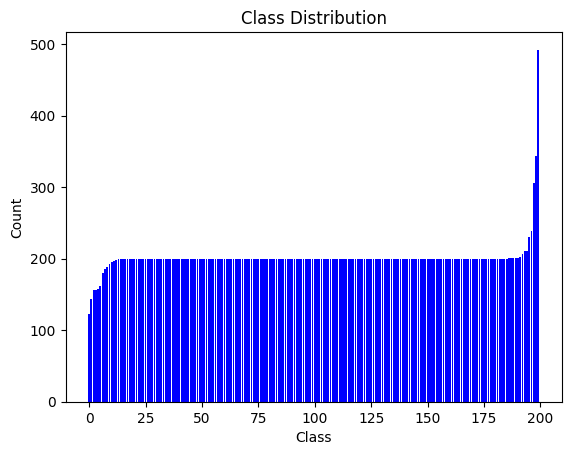

In [ ]:
plot_barchart(y)

### Show a sample from each class

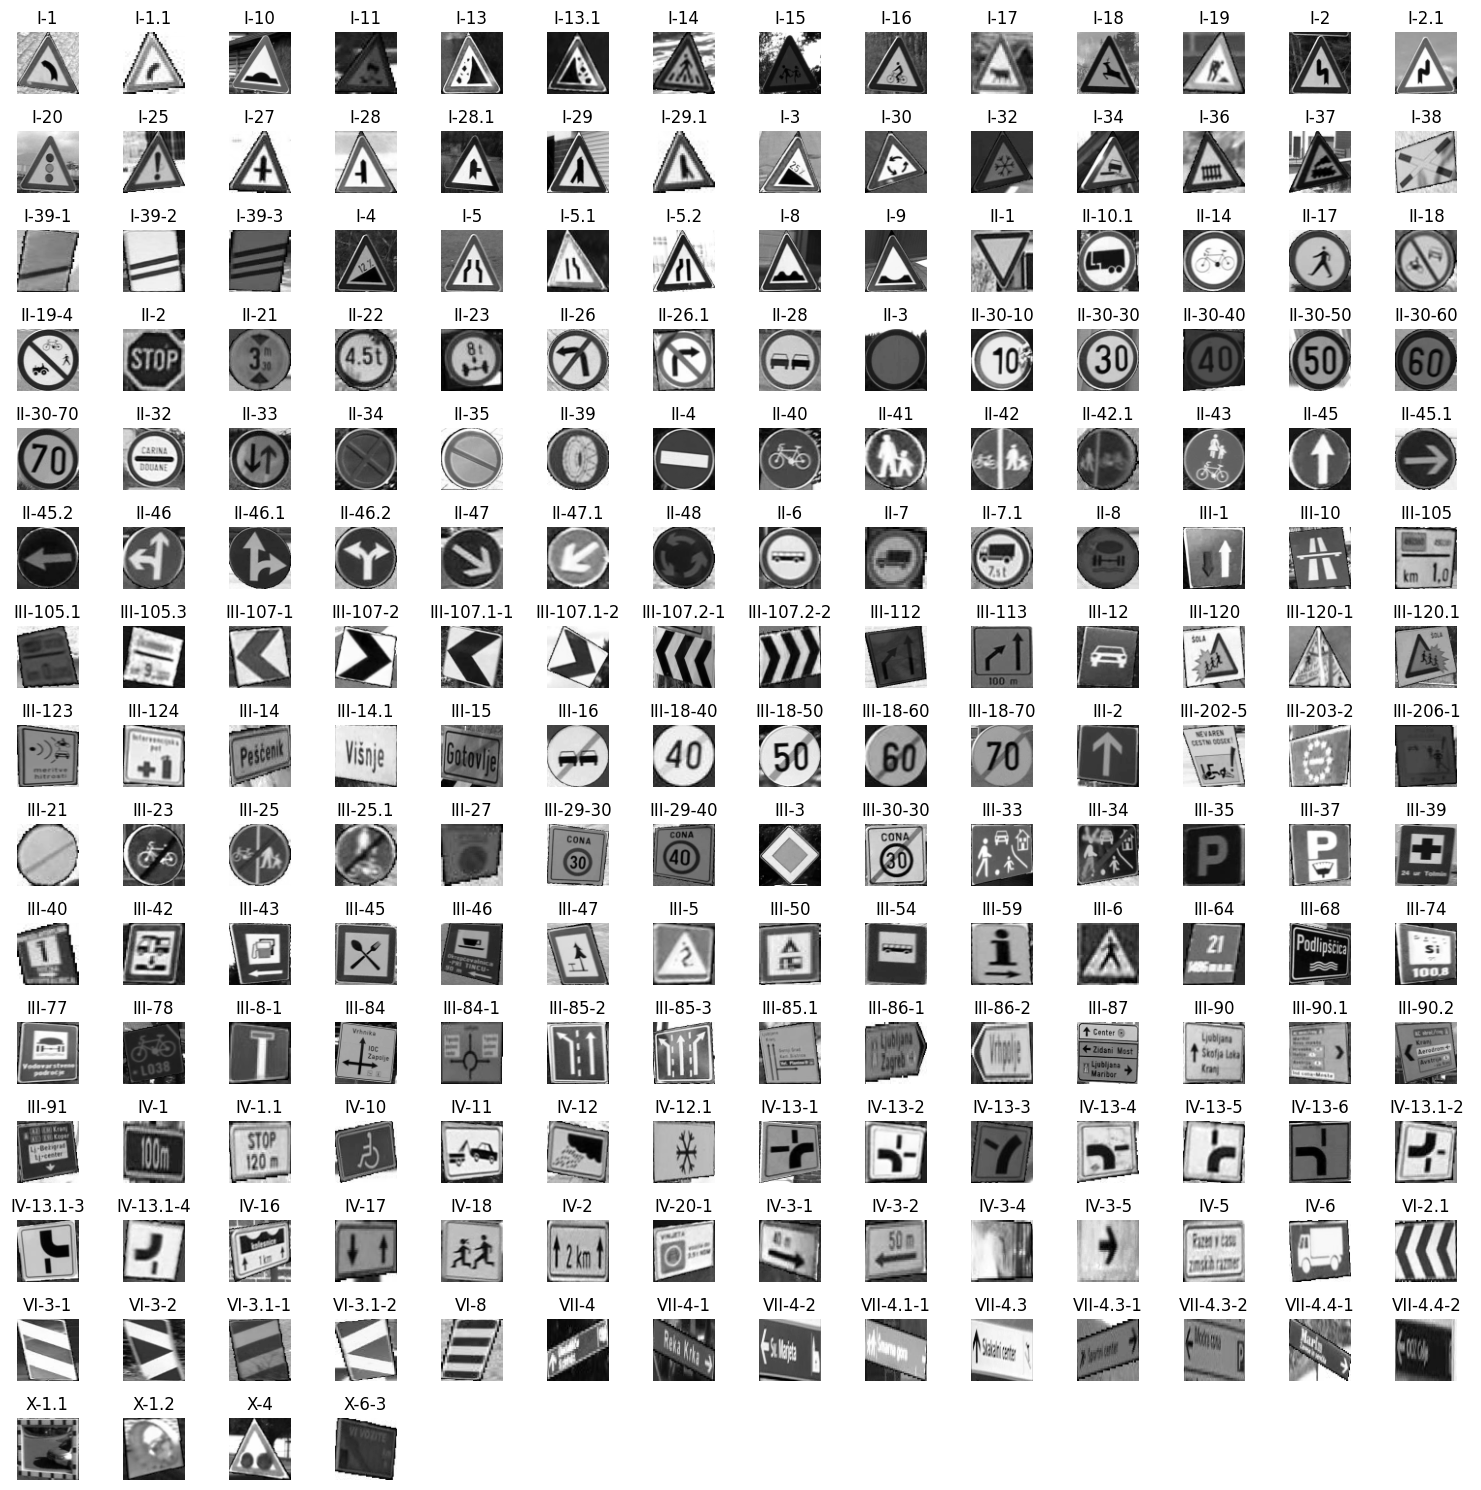

In [ ]:
idx = {}
for i in range(len(y)):
  if y[i] not in idx:
    idx[y[i]] = i

annotations_path = drive_path + "/train-difficult.json"

with open(annotations_path, 'r') as f:
    jsondata = json.load(f)
    categories = jsondata["categories"]

category_id_map = {category["id"]: category["name"] for category in categories}

num_images = 200
num_cols = 14
num_rows = num_images // num_cols + int(num_images % num_cols != 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

axes = axes.flatten()

for k in range(num_images):
    sample_image = db['dataset1_data'][idx[k]]
    ax = axes[k]
    ax.imshow(sample_image, cmap='gray')
    ax.axis('off')
    ax.set_title(category_id_map[k])

for k in range(num_images, len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()

## Load dataset #2

### Load data and save as numpy file

In [ ]:
X_train, X_test, X_valid, y_train, y_test, y_valid = get_data_split(drive_path + "/road-signs-16/train/",
                                                              drive_path + "/road-signs-16/test/",
                                                              drive_path + "/road-signs-16/valid/",
                                                              drive_path + "/road-signs-16/isolated_subjects_train/",
                                                              drive_path + "/road-signs-16/isolated_subjects_test/",
                                                              drive_path + "/road-signs-16/isolated_subjects_valid/")

np.save("X_train.npy", X_train)
np.save("X_test.npy", X_test)
np.save("X_valid.npy", X_valid)
np.save("y_train.npy", y_train)
np.save("y_test.npy", y_test)
np.save("y_valid.npy", y_valid)


### Load numpy arrays and normalize

In [3]:
!cp "$drive_path/road-signs-16/saves/"*.npy .

X_train = np.load("X_train.npy")/255.0
X_test = np.load("X_test.npy")/255.0
X_valid = np.load("X_valid.npy")/255.0
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")
y_valid = np.load("y_valid.npy")

# merge
X = np.concatenate((X_train, X_valid, X_test))
y = np.concatenate((y_train, y_valid, y_test))

# do a custom split (remove classes with only one instance)
X = X[np.isin(y, np.unique(y, return_counts=True)[0][np.unique(y, return_counts=True)[1] > 1])]
y = y[np.isin(y, np.unique(y, return_counts=True)[0][np.unique(y, return_counts=True)[1] > 1])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15)

classes = len(set(y_train))
print(len(set(y_train)))
print(len(set(y_valid)))
print(len(set(y_test)))


# one hot encode classes
bin = LabelBinarizer()
y_train_bin = bin.fit_transform(y_train)
y_test_bin = bin.transform(y_test)
y_valid_bin = bin.transform(y_valid)


164
161
155


### Plot data distribution

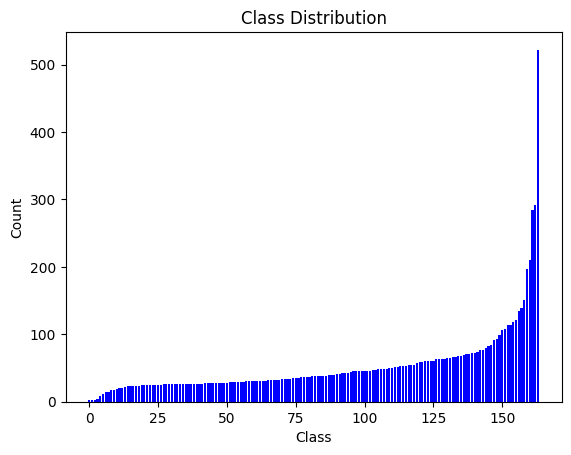

In [ ]:
plot_barchart(y)

### Show a sample from each class

{3: 0, 55: 1, 163: 2, 133: 3, 149: 4, 132: 6, 155: 7, 49: 8, 12: 9, 123: 11, 112: 12, 51: 14, 107: 15, 37: 16, 87: 17, 24: 18, 94: 20, 69: 21, 4: 22, 29: 24, 136: 25, 137: 26, 67: 27, 73: 31, 1: 33, 140: 34, 159: 35, 161: 36, 150: 37, 128: 38, 145: 39, 153: 40, 104: 42, 151: 44, 54: 45, 7: 48, 64: 49, 144: 50, 36: 51, 157: 52, 143: 54, 11: 55, 119: 57, 162: 59, 66: 61, 27: 62, 105: 63, 43: 65, 23: 66, 13: 67, 131: 69, 2: 77, 125: 82, 100: 83, 35: 85, 56: 86, 116: 87, 44: 91, 130: 94, 88: 95, 95: 96, 156: 97, 65: 98, 61: 101, 139: 102, 148: 104, 9: 106, 91: 107, 101: 108, 93: 114, 18: 115, 113: 118, 160: 121, 62: 123, 8: 134, 106: 135, 31: 138, 21: 141, 114: 142, 102: 143, 117: 145, 74: 146, 53: 147, 72: 148, 59: 149, 57: 150, 165: 151, 109: 152, 110: 161, 152: 168, 97: 179, 78: 183, 50: 185, 147: 191, 126: 192, 99: 193, 48: 194, 68: 196, 16: 197, 71: 200, 98: 202, 90: 203, 30: 204, 39: 208, 124: 211, 15: 214, 20: 225, 129: 232, 111: 236, 158: 241, 77: 244, 164: 249, 25: 265, 52: 269, 1

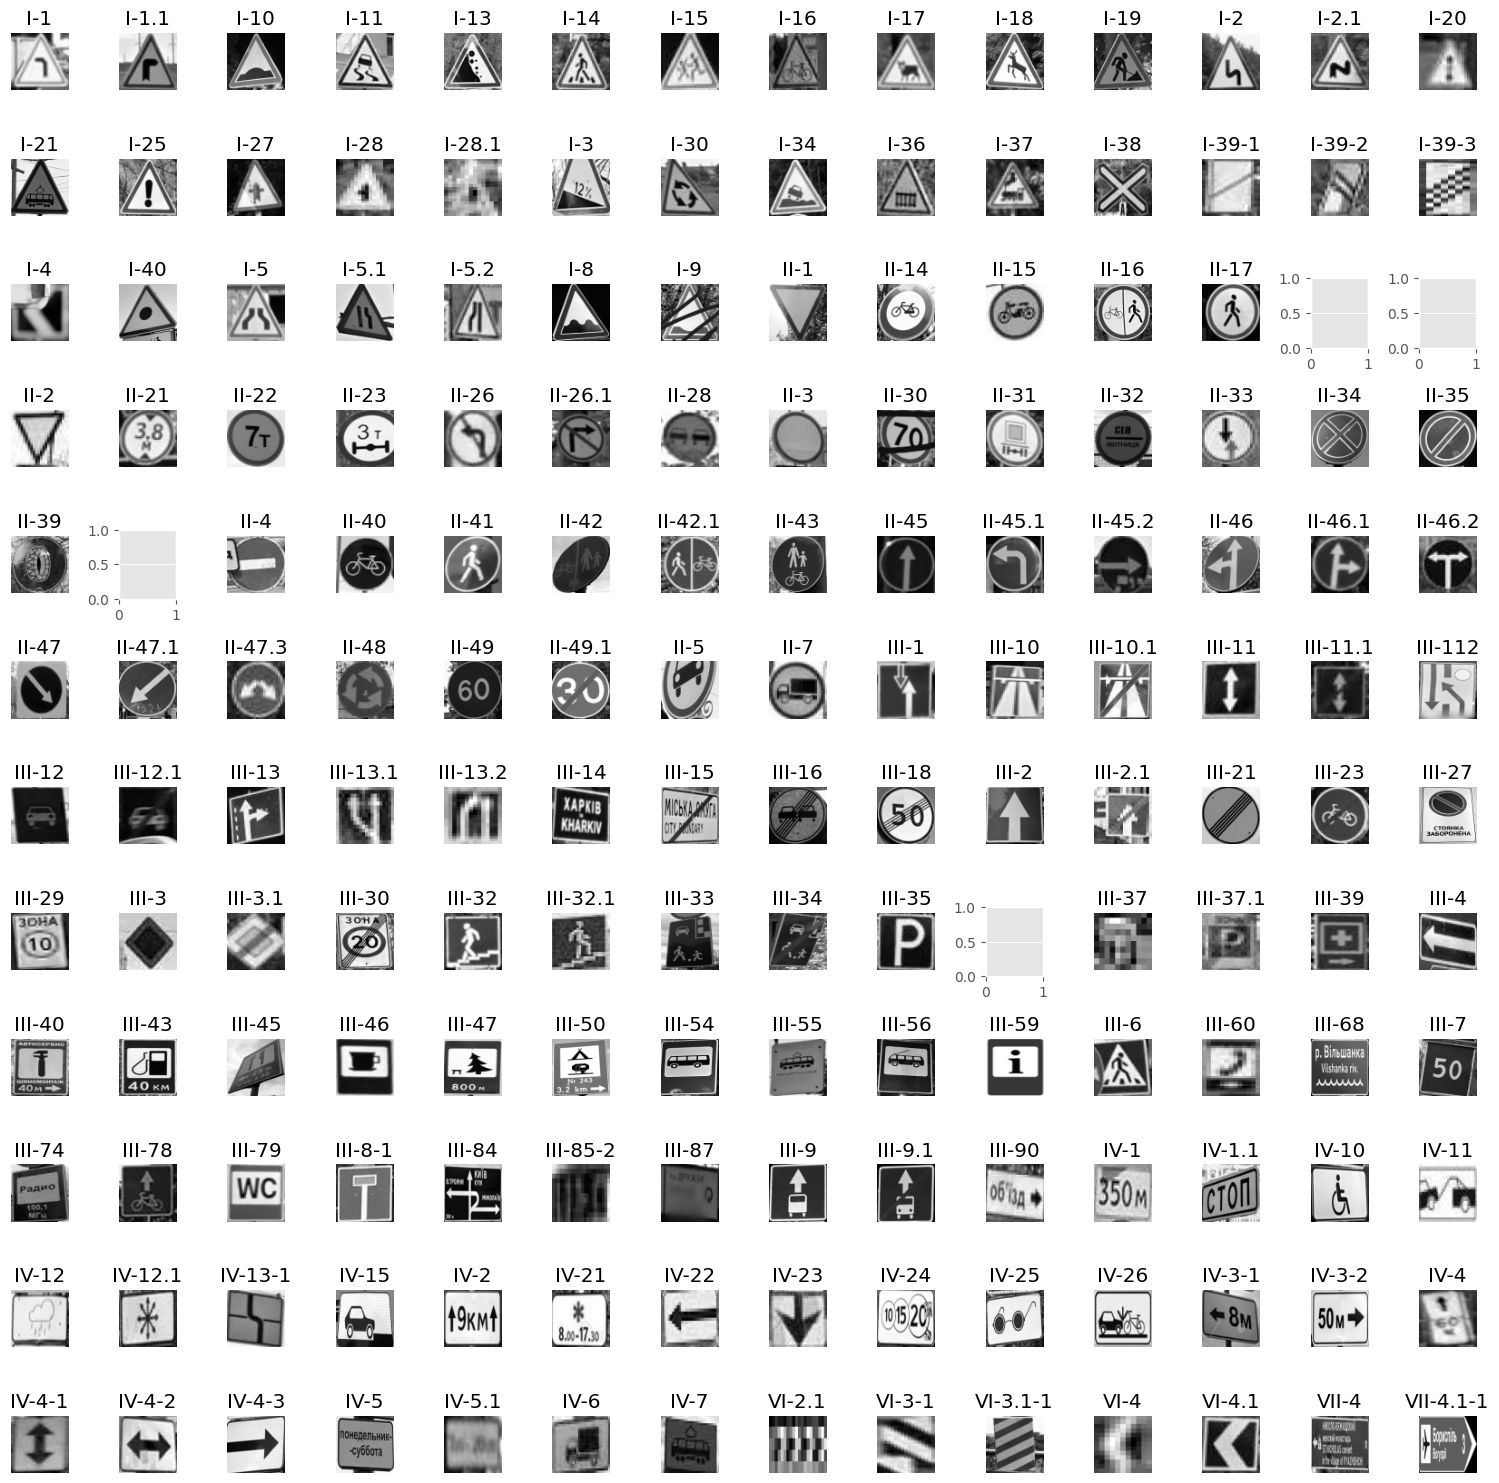

In [ ]:
idx = {}
for i in range(len(y_train)):
  if y_train[i] not in idx:
    idx[y_train[i]] = i

print(idx)

annotations_path = drive_path + "/road-signs-16/train/_annotations.coco.json"

with open(annotations_path, 'r') as f:
    jsondata = json.load(f)
    categories = jsondata["categories"]

category_id_map = {category["id"]: category["name"] for category in categories}

num_images = 168
num_cols = 14
num_rows = num_images // num_cols + int(num_images % num_cols != 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

axes = axes.flatten()

for k in range(1, num_images+1):
    if k not in idx:
        continue

    sample_image = X_train[idx[k]]
    ax = axes[k-1]
    ax.imshow(sample_image, cmap='gray')
    ax.axis('off')
    ax.set_title(category_id_map[k])

for k in range(num_images, len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()

# Algorithms

## ShallowNet

### Dataset #1

In [7]:
batch_size = 32
train_batches = generate_batches(train_indices, batch_size)
test_batches = generate_batches(test_indices, batch_size)
classes = len(set(y))
n_epochs = 100

model = Sequential()
inputShape = (64, 64, 1)
model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dense(classes))
model.add(Activation("softmax"))

print("[INFO] compiling model...")
model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.005), metrics=["accuracy"])

print("[INFO] training network...")
H = model.fit(x=train_batches,
          steps_per_epoch=len(train_indices) // batch_size,
          epochs=n_epochs,
          validation_data=test_batches,
          validation_steps=len(test_indices) // batch_size)

[INFO] compiling model...
[INFO] training network...
Epoch 1/100
1006/1006 [==============================] - 13s 12ms/step - loss: 3.6099 - accuracy: 0.3080 - val_loss: 2.4927 - val_accuracy: 0.5113
Epoch 2/100
1006/1006 [==============================] - 13s 12ms/step - loss: 2.1087 - accuracy: 0.5871 - val_loss: 1.9161 - val_accuracy: 0.6024
Epoch 3/100
1006/1006 [==============================] - 11s 11ms/step - loss: 1.6760 - accuracy: 0.6607 - val_loss: 1.7277 - val_accuracy: 0.6409
Epoch 4/100
1006/1006 [==============================] - 11s 11ms/step - loss: 1.4317 - accuracy: 0.7060 - val_loss: 1.6650 - val_accuracy: 0.6505
Epoch 5/100
1006/1006 [==============================] - 15s 15ms/step - loss: 1.2551 - accuracy: 0.7406 - val_loss: 1.7002 - val_accuracy: 0.6473
Epoch 6/100
1006/1006 [==============================] - 21s 21ms/step - loss: 1.1006 - accuracy: 0.7723 - val_loss: 1.5395 - val_accuracy: 0.6822
Epoch 7/100
1006/1006 [==============================] - 12s 12ms

### Dataset #2

In [4]:
n_epochs = 100

model = Sequential()
inputShape = (64, 64, 1)
model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dense(classes))
model.add(Activation("softmax"))

print("[INFO] compiling model...")
model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.005), metrics=["accuracy"])

print("[INFO] training network...")
H = model.fit(X_train, y_train_bin, validation_data=(X_valid, y_valid_bin), batch_size=32, epochs=n_epochs, verbose=1)

[INFO] compiling model...
[INFO] training network...
Epoch 1/100
207/207 [==============================] - 4s 10ms/step - loss: 4.5884 - accuracy: 0.1170 - val_loss: 4.4319 - val_accuracy: 0.1279
Epoch 2/100
207/207 [==============================] - 2s 8ms/step - loss: 3.5644 - accuracy: 0.2873 - val_loss: 5.2806 - val_accuracy: 0.1657
Epoch 3/100
207/207 [==============================] - 2s 11ms/step - loss: 2.8249 - accuracy: 0.4302 - val_loss: 6.9700 - val_accuracy: 0.1468
Epoch 4/100
207/207 [==============================] - 2s 10ms/step - loss: 2.2974 - accuracy: 0.5217 - val_loss: 6.4136 - val_accuracy: 0.2335
Epoch 5/100
207/207 [==============================] - 2s 9ms/step - loss: 2.0033 - accuracy: 0.5974 - val_loss: 3.4845 - val_accuracy: 0.3768
Epoch 6/100
207/207 [==============================] - 2s 8ms/step - loss: 1.7499 - accuracy: 0.6368 - val_loss: 3.1096 - val_accuracy: 0.4378
Epoch 7/100
207/207 [==============================] - 2s 8ms/step - loss: 1.6013 - ac

## LeNet

### Dataset #1

In [ ]:
batch_size = 32
train_batches = generate_batches(train_indices, batch_size)
test_batches = generate_batches(test_indices, batch_size)
classes = len(set(y))
n_epochs = 20

model = Sequential()
inputShape = (64, 64, 1)
model.add(Conv2D(20, (5, 5), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(50, (5, 5), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(500))
model.add(Activation("relu"))
model.add(Dense(classes))
model.add(Activation("softmax"))

print("[INFO] compiling model...")
model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.005), metrics=["accuracy"])

print("[INFO] training network...")
H = model.fit(x=train_batches,
          steps_per_epoch=len(train_indices) // batch_size,
          epochs=n_epochs,
          validation_data=test_batches,
          validation_steps=len(test_indices) // batch_size)

[INFO] compiling model...
[INFO] training network...
Epoch 1/20
1006/1006 [==============================] - 12s 10ms/step - loss: 5.0123 - accuracy: 0.0501 - val_loss: 3.5664 - val_accuracy: 0.2747
Epoch 2/20
1006/1006 [==============================] - 9s 8ms/step - loss: 2.0605 - accuracy: 0.5381 - val_loss: 1.3320 - val_accuracy: 0.6931
Epoch 3/20
1006/1006 [==============================] - 10s 10ms/step - loss: 1.0068 - accuracy: 0.7541 - val_loss: 0.9968 - val_accuracy: 0.7542
Epoch 4/20
1006/1006 [==============================] - 10s 10ms/step - loss: 0.6441 - accuracy: 0.8362 - val_loss: 0.8237 - val_accuracy: 0.8004
Epoch 5/20
1006/1006 [==============================] - 8s 8ms/step - loss: 0.4435 - accuracy: 0.8849 - val_loss: 0.6762 - val_accuracy: 0.8363
Epoch 6/20
1006/1006 [==============================] - 10s 10ms/step - loss: 0.3172 - accuracy: 0.9148 - val_loss: 0.6847 - val_accuracy: 0.8422
Epoch 7/20
1006/1006 [==============================] - 10s 10ms/step - los

### Dataset #2

In [ ]:
n_epochs = 50

model = Sequential()
inputShape = (64, 64, 1)
model.add(Conv2D(20, (5, 5), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(50, (5, 5), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(500))
model.add(Activation("relu"))
model.add(Dense(classes))
model.add(Activation("softmax"))

print("[INFO] compiling model...")
model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.01), metrics=["accuracy"])

print("[INFO] training network...")
H = model.fit(X_train, y_train_bin, validation_data=(X_valid, y_valid_bin), batch_size=128, epochs=n_epochs, verbose=1)

[INFO] compiling model...
[INFO] training network...
Epoch 1/50
52/52 [==============================] - 5s 45ms/step - loss: 5.0287 - accuracy: 0.0338 - val_loss: 4.8579 - val_accuracy: 0.0670
Epoch 2/50
52/52 [==============================] - 1s 28ms/step - loss: 4.8348 - accuracy: 0.0623 - val_loss: 4.7478 - val_accuracy: 0.0721
Epoch 3/50
52/52 [==============================] - 2s 30ms/step - loss: 4.7442 - accuracy: 0.0794 - val_loss: 4.6626 - val_accuracy: 0.1056
Epoch 4/50
52/52 [==============================] - 2s 29ms/step - loss: 4.6281 - accuracy: 0.1165 - val_loss: 4.5471 - val_accuracy: 0.1485
Epoch 5/50
52/52 [==============================] - 1s 28ms/step - loss: 4.4538 - accuracy: 0.1423 - val_loss: 4.3491 - val_accuracy: 0.1639
Epoch 6/50
52/52 [==============================] - 1s 28ms/step - loss: 4.3059 - accuracy: 0.1564 - val_loss: 4.2441 - val_accuracy: 0.1811
Epoch 7/50
52/52 [==============================] - 2s 31ms/step - loss: 4.0570 - accuracy: 0.1894 - 

## MiniVGGNet

### Dataset #1

In [ ]:
batch_size = 32
train_batches = generate_batches(train_indices, batch_size)
test_batches = generate_batches(test_indices, batch_size)
classes = len(set(y))
n_epochs = 20

chanDim = 1

model = Sequential()
inputShape = (64, 64, 1)

model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(Activation("softmax"))

print("[INFO] compiling model...")
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

print("[INFO] training network...")
H = model.fit(x=train_batches,
          steps_per_epoch=len(train_indices) // batch_size,
          epochs=n_epochs,
          validation_data=test_batches,
          validation_steps=len(test_indices) // batch_size)

[INFO] compiling model...
[INFO] training network...
Epoch 1/20
1006/1006 [==============================] - 31s 21ms/step - loss: 1.5469 - accuracy: 0.6606 - val_loss: 0.3742 - val_accuracy: 0.8940
Epoch 2/20
1006/1006 [==============================] - 21s 21ms/step - loss: 0.3191 - accuracy: 0.9148 - val_loss: 0.1834 - val_accuracy: 0.9472
Epoch 3/20
1006/1006 [==============================] - 20s 20ms/step - loss: 0.1707 - accuracy: 0.9521 - val_loss: 0.2924 - val_accuracy: 0.9240
Epoch 4/20
1006/1006 [==============================] - 21s 21ms/step - loss: 0.1407 - accuracy: 0.9578 - val_loss: 0.2311 - val_accuracy: 0.9422
Epoch 5/20
1006/1006 [==============================] - 20s 20ms/step - loss: 0.1014 - accuracy: 0.9686 - val_loss: 0.1651 - val_accuracy: 0.9579
Epoch 6/20
1006/1006 [==============================] - 21s 21ms/step - loss: 0.1014 - accuracy: 0.9696 - val_loss: 0.2351 - val_accuracy: 0.9491
Epoch 7/20
1006/1006 [==============================] - 21s 21ms/step -

In [ ]:
model.save('VGG DFG.keras')
!cp *.keras "$drive_path/saves_DFG/"

### Dataset #2

In [ ]:
n_epochs = 35
chanDim = 1

model = Sequential()
inputShape = (64, 64, 1)

model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(Activation("softmax"))

print("[INFO] compiling model...")
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

print("[INFO] training network...")
H = model.fit(X_train, y_train_bin, validation_data=(X_valid, y_valid_bin), batch_size=128, epochs=n_epochs, verbose=1)

[INFO] compiling model...
[INFO] training network...
Epoch 1/35
52/52 [==============================] - 10s 63ms/step - loss: 3.8190 - accuracy: 0.2585 - val_loss: 5.2696 - val_accuracy: 0.0609
Epoch 2/35
52/52 [==============================] - 3s 56ms/step - loss: 1.7389 - accuracy: 0.6172 - val_loss: 4.9659 - val_accuracy: 0.0850
Epoch 3/35
52/52 [==============================] - 3s 56ms/step - loss: 0.9333 - accuracy: 0.7969 - val_loss: 4.3841 - val_accuracy: 0.0996
Epoch 4/35
52/52 [==============================] - 3s 57ms/step - loss: 0.5525 - accuracy: 0.8803 - val_loss: 3.4632 - val_accuracy: 0.2678
Epoch 5/35
52/52 [==============================] - 3s 59ms/step - loss: 0.3214 - accuracy: 0.9373 - val_loss: 2.5206 - val_accuracy: 0.3940
Epoch 6/35
52/52 [==============================] - 3s 57ms/step - loss: 0.1925 - accuracy: 0.9665 - val_loss: 1.8035 - val_accuracy: 0.5948
Epoch 7/35
52/52 [==============================] - 3s 57ms/step - loss: 0.1215 - accuracy: 0.9835 -

In [ ]:
model.save('VGG RSV.keras')
!cp *.keras "$drive_path/road-signs-16/saves"

## Plot history

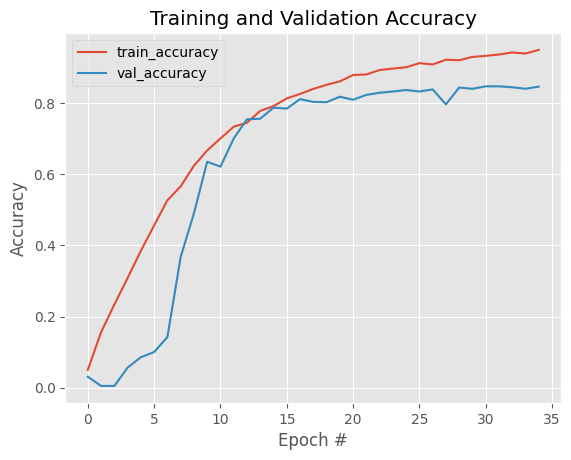

In [ ]:
plt.style.use("ggplot")
plt.figure()
# plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, n_epochs), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, n_epochs), H.history["val_accuracy"], label="val_accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Test

### Dataset #1

In [9]:
# model = load_model(drive_path + "/saves_DFG/VGG DFG.keras")
batch_size = 32
classes = len(set(y))

# Initialize empty lists to store predictions and actual values
all_y_pred = []
all_y_true = []
all_X = []

# Create an instance of the test batch generator
test_batch_gen = generate_batches(test_indices, batch_size)

# Calculate the number of batches to cover the entire test set
num_test_samples = len(test_indices)
num_batches = int(np.ceil(num_test_samples / batch_size))

# Iterate over the test batches and collect predictions
for _ in range(num_batches):
    X_batch, y_batch = next(test_batch_gen)

    # Make predictions for the batch
    y_pred_batch = model.predict(X_batch)

    # Convert predictions to binary values
    y_pred_batch = np.array([[0 if x < 0.5 else 1 for x in y] for y in y_pred_batch])

    # Store the predictions and actual values
    all_y_pred.extend(y_pred_batch)
    all_y_true.extend(y_batch)
    all_X.extend(X_batch)

# Convert lists to numpy arrays
all_y_pred = np.array(all_y_pred)
all_y_true = np.array(all_y_true)

# Inverse transform the predictions if necessary
all_y_pred = bin.inverse_transform(all_y_pred)

# Inverse transform the ground truth labels
y_valid = bin.inverse_transform(all_y_true)

# Print the classification report
print("Classification report:")
print(classification_report(y_valid, all_y_pred))

1/1 [==============================] - 0s 50ms/step
Classification report:
              precision    recall  f1-score   support

           0       0.07      0.70      0.13        40
           1       0.67      0.78      0.72        40
           2       0.95      0.88      0.91        40
           3       0.87      0.68      0.76        40
           4       0.85      0.72      0.78        40
           5       0.89      0.80      0.84        40
           6       0.92      0.85      0.88        40
           7       0.83      0.62      0.71        40
           8       0.65      0.82      0.73        40
           9       0.81      0.72      0.76        40
          10       0.74      0.78      0.76        40
          11       0.70      0.80      0.74        40
          12       0.65      0.55      0.59        40
          13       0.76      0.72      0.74        40
          14       0.80      0.60      0.69        40
          15       0.77      0.68      0.72        40
      

In [ ]:
y_pred_0_idx = [i for i, label in enumerate(all_y_pred) if label == 0]
y_true = y_valid[y_pred_0_idx]

for idx in y_pred_0_idx:
  sample_image = all_X[idx]

  plt.imshow(sample_image, cmap='gray')
  plt.axis('off')
  plt.show()

In [ ]:
report = classification_report(y_valid, all_y_pred, output_dict=True)

precisions = []
class_labels = []
for label, metrics in report.items():
    if label != 'accuracy' and label != 'macro avg' and label != 'weighted avg':
        precisions.append(metrics['precision'])
        class_labels.append(label)

precisions_sorted = np.sort(precisions)
x_values = range(len(precisions))

plt.bar(x_values, precisions_sorted, color='blue')
plt.xlabel('')
plt.ylabel('Precision')
plt.title('Precisions sorted')
plt.show()

In [ ]:
report = classification_report(y_valid, all_y_pred, output_dict=True)

precisions = []
class_labels = []
for label, metrics in report.items():
    if label != 'accuracy' and label != 'macro avg' and label != 'weighted avg':
        precisions.append(metrics['recall'])
        class_labels.append(label)

precisions_sorted = np.sort(precisions)
x_values = range(len(precisions))

plt.bar(x_values, precisions_sorted, color='blue')
plt.xlabel('')
plt.ylabel('Recall')
plt.title('Recall sorted')
plt.show()

### Dataset #2

In [5]:
# model = load_model(drive_path + "/road-signs-16/saves/VGG RSV.keras")

y_pred = model.predict(X_valid)
y_pred = np.array([[0 if x < 0.5 else 1 for x in y] for y in y_pred])
y_pred = bin.inverse_transform(y_pred)

print("Classification report:")
print(classification_report(y_valid, y_pred))

37/37 [==============================] - 1s 6ms/step
Classification report:
              precision    recall  f1-score   support

           1       0.06      0.88      0.11         8
           2       0.86      0.86      0.86         7
           3       0.71      0.83      0.77         6
           4       0.94      0.84      0.89        19
           5       0.00      0.00      0.00         2
           6       1.00      0.30      0.46        10
           7       0.62      0.71      0.67         7
           8       0.86      0.46      0.60        13
           9       1.00      1.00      1.00         2
          10       1.00      0.50      0.67         2
          11       0.70      0.82      0.76        17
          12       0.20      0.50      0.29         2
          13       0.67      0.40      0.50         5
          14       0.00      0.00      0.00         0
          15       1.00      0.33      0.50         3
          16       0.62      0.56      0.59         9
     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

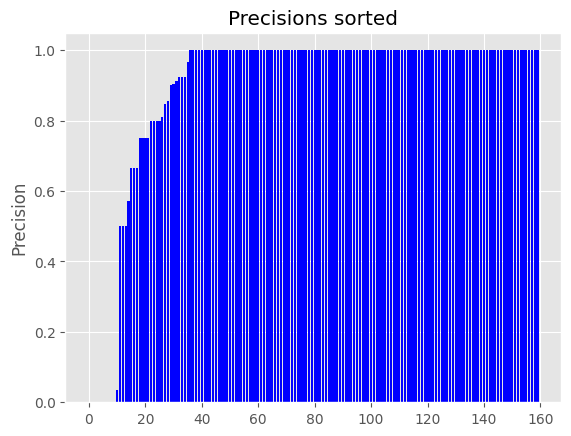

In [ ]:
report = classification_report(y_valid, y_pred, output_dict=True)

precisions = []
class_labels = []
for label, metrics in report.items():
    if label != 'accuracy' and label != 'macro avg' and label != 'weighted avg':
        precisions.append(metrics['precision'])
        class_labels.append(label)

precisions_sorted = np.sort(precisions)
x_values = range(len(precisions))

plt.bar(x_values, precisions_sorted, color='blue')
plt.xlabel('')
plt.ylabel('Precision')
plt.title('Precisions sorted')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

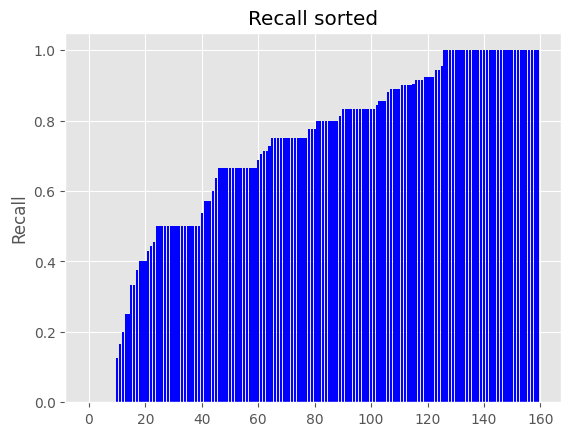

In [ ]:
report = classification_report(y_valid, y_pred, output_dict=True)

precisions = []
class_labels = []
for label, metrics in report.items():
    if label != 'accuracy' and label != 'macro avg' and label != 'weighted avg':
        precisions.append(metrics['recall'])
        class_labels.append(label)

precisions_sorted = np.sort(precisions)
x_values = range(len(precisions))

plt.bar(x_values, precisions_sorted, color='blue')
plt.xlabel('')
plt.ylabel('Recall')
plt.title('Recall sorted')
plt.show()

## Object detection

### Pre-processing

In [ ]:
!mkdir processed_train processed_test processed_valid

jpg_files = [drive_path + "/road-signs-16/train/" + f for f in os.listdir(drive_path + "/road-signs-16/train/") if f.endswith('.jpg')]
preprocess_images(jpg_files, drive_path + "/road-signs-16/train/_annotations.coco.json", "processed_train")

jpg_files = [drive_path + "/road-signs-16/test/" + f for f in os.listdir(drive_path + "/road-signs-16/test/") if f.endswith('.jpg')]
preprocess_images(jpg_files, drive_path + "/road-signs-16/test/_annotations.coco.json", "processed_test")

jpg_files = [drive_path + "/road-signs-16/valid/" + f for f in os.listdir(drive_path + "/road-signs-16/valid/") if f.endswith('.jpg')]
preprocess_images(jpg_files, drive_path + "/road-signs-16/valid/_annotations.coco.json", "processed_valid")

In [ ]:
!cp -r processed_train processed_test processed_valid "$drive_path/road-signs-16/"

^C


In [ ]:
def resize_bbox(bbox, scale_x, scale_y):
    x, y, width, height = bbox
    return [x * scale_x, y * scale_y, width * scale_x, height * scale_y]

def resize_annotations(input_json, output_json, original_size, new_size):
    with open(input_json, 'r') as f:
        coco_data = json.load(f)

    original_width, original_height = original_size
    new_width, new_height = new_size

    scale_x = new_width / original_width
    scale_y = new_height / original_height

    for annotation in coco_data['annotations']:
        annotation['bbox'] = resize_bbox(annotation['bbox'], scale_x, scale_y)

    for image in coco_data['images']:
        image['width'] = new_width
        image['height'] = new_height
        image['file_name'] = f"{image['id']}.png"

    with open(output_json, 'w') as f:
        json.dump(coco_data, f, indent=4)

def filter_coco_annotations(input_path, class_ids, output_path):
    with open(input_path, 'r') as f:
        coco_data = json.load(f)

    # category_ids = [category['id'] for category in coco_data['categories'] if category['name'] in class_names]
    filtered_annotations = [ann for ann in coco_data['annotations'] if ann['category_id'] in class_ids]
    image_ids = list(set([ann['image_id'] for ann in filtered_annotations]))
    filtered_images = [img for img in coco_data['images'] if img['id'] in image_ids]
    filtered_categories = [category for category in coco_data['categories'] if category['id'] in class_ids]

    filtered_coco_data = {
        'images': filtered_images,
        'annotations': filtered_annotations,
        'categories': filtered_categories
    }

    with open(output_path, 'w') as f:
        json.dump(filtered_coco_data, f, indent=4)

classes = []
for i in range(27):
  classes.append(i)

for i in range(31, 36+1):
  classes.append(i)

filter_coco_annotations(drive_path + "/train.json", classes, drive_path + "/train_truncated.json")
filter_coco_annotations(drive_path + "/test.json", classes, drive_path + "/test_truncated.json")

filter_coco_annotations(drive_path + "/road-signs-16/train/_annotations.coco.json", classes, drive_path + "/road-signs-16/processed_train/_annotations_truncated.coco.json")
filter_coco_annotations(drive_path + "/road-signs-16/test/_annotations.coco.json", classes, drive_path + "/road-signs-16/processed_test/_annotations_truncated.coco.json")
filter_coco_annotations(drive_path + "/road-signs-16/valid/_annotations.coco.json", classes, drive_path + "/road-signs-16/processed_valid/_annotations_truncated.coco.json")

resize_annotations(drive_path + "/road-signs-16/processed_train/_annotations_truncated.coco.json", drive_path + "/road-signs-16/processed_train/_annotations.coco.json", (640, 640), (256, 256))
resize_annotations(drive_path + "/road-signs-16/processed_test/_annotations_truncated.coco.json", drive_path + "/road-signs-16/processed_test/_annotations.coco.json", (640, 640), (256, 256))
resize_annotations(drive_path + "/road-signs-16/processed_valid/_annotations_truncated.coco.json", drive_path + "/road-signs-16/processed_valid/_annotations.coco.json", (640, 640), (256, 256))

# from google.colab import drive
# drive.flush_and_unmount()
# drive.mount('/content/drive')

### Install Detectron2

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# import torch, detectron2
# !nvcc --version
# TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
# CUDA_VERSION = torch.__version__.split("+")[-1]
# print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# print("detectron2:", detectron2.__version__)

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-lqizzfpv
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-lqizzfpv
  Resolved https://github.com/facebookresearch/detectron2.git to commit 0df2d73d0013db7de629602c23cc120219b4f2b8
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 19.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6174474 sha256=9cd3d93a67831cd1fcd44f552d3

### Setup

In [ ]:
import os
import torch
import detectron2
import detectron2.model_zoo

from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer

# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# DFG original dataset
train_json = drive_path + "/train.json"
train_images = drive_path + "/JPEGImages/"
test_json = drive_path + "/test.json"
test_images = drive_path + "/JPEGImages/"

register_coco_instances("dfg_dataset_train_orig", {}, train_json, train_images)
register_coco_instances("dfg_dataset_test_orig", {}, test_json, test_images)

# DFG truncated dataset
train_json = drive_path + "/train_truncated.json"
train_images = drive_path + "/JPEGImages/"
test_json = drive_path + "/test_truncated.json"
test_images = drive_path + "/JPEGImages/"

register_coco_instances("dfg_dataset_train", {}, train_json, train_images)
register_coco_instances("dfg_dataset_test", {}, test_json, test_images)

# RSV truncated dataset
train_json = drive_path + "/road-signs-16/processed_train/_annotations_truncated.coco.json"
train_images = drive_path + "/road-signs-16/train/"
valid_json = drive_path + "/road-signs-16/processed_valid/_annotations_truncated.coco.json"
valid_images = drive_path + "/road-signs-16/valid/"
test_json = drive_path + "/road-signs-16/processed_test/_annotations_truncated.coco.json"
test_images = drive_path + "/road-signs-16/test/"

register_coco_instances("my_dataset_train", {}, train_json, train_images)
register_coco_instances("my_dataset_valid", {}, valid_json, valid_images)
register_coco_instances("my_dataset_test", {}, test_json, test_images)

# RSV truncated+grayscale dataset
train_json = drive_path + "/road-signs-16/processed_train/_annotations.coco.json"
train_images = drive_path + "/road-signs-16/processed_train/"
valid_json = drive_path + "/road-signs-16/processed_valid/_annotations.coco.json"
valid_images = drive_path + "/road-signs-16/processed_valid/"
test_json = drive_path + "/road-signs-16/processed_test/_annotations.coco.json"
test_images = drive_path + "/road-signs-16/processed_test/"

register_coco_instances("my_dataset_train_gs", {}, train_json, train_images)
register_coco_instances("my_dataset_valid_gs", {}, valid_json, valid_images)
register_coco_instances("my_dataset_test_gs", {}, test_json, test_images)

### Dataset #1

In [ ]:
# Set up configuration
cfg = get_cfg()
cfg.merge_from_file(detectron2.model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("dfg_dataset_train2",)
cfg.DATASETS.TEST = ("dfg_dataset_test2",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = drive_path + "/model_final_DFG_5000epochs_.pth"
# cfg.MODEL.WEIGHTS = detectron2.model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Use pre-trained weights
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 5000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 33 # 200

# Create the output directory
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Initialize the trainer and start training
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# import locale
# locale.getpreferredencoding = lambda: "UTF-8"
# !cp output/model_final.pth "$drive_path/model_final_DFG_5000epochs.pth"
# from google.colab import drive
# drive.flush_and_unmount()
# drive.mount('/content/drive')

[06/02 11:42:41 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/02 11:42:59 d2.utils.events]:  eta: 0:54:57  iter: 19  total_loss: 0.2143  loss_cls: 0.105  loss_box_reg: 0.1223  loss_rpn_cls: 5.872e-05  loss_rpn_loc: 0.001896    time: 0.7063  last_time: 0.6210  data_time: 0.0596  last_data_time: 0.0182   lr: 4.9953e-06  max_mem: 4695M
[06/02 11:43:14 d2.utils.events]:  eta: 0:57:45  iter: 39  total_loss: 0.2264  loss_cls: 0.1046  loss_box_reg: 0.1056  loss_rpn_cls: 1.012e-05  loss_rpn_loc: 0.001595    time: 0.7208  last_time: 0.8413  data_time: 0.0167  last_data_time: 0.0256   lr: 9.9902e-06  max_mem: 4695M
[06/02 11:43:28 d2.utils.events]:  eta: 0:56:10  iter: 59  total_loss: 0.2749  loss_cls: 0.1521  loss_box_reg: 0.1097  loss_rpn_cls: 1.424e-05  loss_rpn_loc: 0.001386    time: 0.7090  last_time: 0.6006  data_time: 0.0169  last_data_time: 0.0172   lr: 1.4985e-05  max_mem: 4695M
[06/02 11:43:46 d2.utils.events]:  eta: 0:58:50  iter: 79  total_loss: 0.1793  loss_cls: 0.07944  loss_box_reg: 0.09732  loss_rpn_cls: 3.295e-05  loss_rpn_loc: 0.00165

KeyboardInterrupt: 

### Dataset #2

In [ ]:
# Set up configuration
cfg = get_cfg()
cfg.merge_from_file(detectron2.model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train_gs",)
cfg.DATASETS.TEST = ("my_dataset_valid_gs",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = detectron2.model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Use pre-trained weights
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 5000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 33 # 168

# Create the output directory
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Initialize the trainer and start training
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

import locale
locale.getpreferredencoding = lambda: "UTF-8"
!cp output/model_final.pth "$drive_path/model_final_VANGA_GS_5000epochs.pth"
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


### Test (#1)

In [ ]:
from google.colab.patches import cv2_imshow
from detectron2.utils.visualizer import Visualizer, ColorMode, _create_text_labels
from detectron2.structures import Boxes, BoxMode, Instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# cfg = get_cfg()
# cfg.MODEL.DEVICE = "cpu"
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 33
cfg.MODEL.WEIGHTS = drive_path + "/model_final_DFG_5000epochs.pth"
cfg.DATASETS.TEST = ("dfg_dataset_test2",)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.15 # ignore predictions with less than 15% confidence
predictor = DefaultPredictor(cfg)

test_loader = build_detection_test_loader(cfg, "dfg_dataset_test2")
evaluator = COCOEvaluator("dfg_dataset_test2", cfg, False, output_dir="./output/")
metrics = inference_on_dataset(predictor.model, test_loader, evaluator)

print("Evaluation:")
print(metrics)

test_metadata = MetadataCatalog.get("dfg_dataset_test2")
test_dataset_dicts = DatasetCatalog.get("dfg_dataset_test2")

# Remove overlapping predictions and keep only the most confident
def non_max_suppression(boxes, scores, iou_threshold):
    indices = cv2.dnn.NMSBoxes(boxes.tolist(), scores.tolist(), score_threshold=0.0, nms_threshold=iou_threshold)
    return indices.flatten()

# Custom visualizer to prevent labels from covering the bounding box
class CustomVisualizer(Visualizer):
    def draw_instance_predictions(self, predictions):
        boxes = predictions.pred_boxes if predictions.has("pred_boxes") else None
        scores = predictions.scores if predictions.has("scores") else None
        classes = predictions.pred_classes if predictions.has("pred_classes") else None
        labels = _create_text_labels(classes, scores, self.metadata.get("thing_classes", None))
        keypoints = predictions.pred_keypoints if predictions.has("pred_keypoints") else None

        if boxes is not None:
            boxes = BoxMode.convert(boxes.tensor.cpu().numpy(), BoxMode.XYXY_ABS, BoxMode.XYXY_ABS)

        if boxes is not None:
            for box, label in zip(boxes, labels):
                color = (1.0, 1.0, 1.0)  # White color in RGBA format
                self.draw_box(box, edge_color=color)
                x, y = box[:2]
                self.draw_text(label, (x + 30, y - 30), color=color)

        return self.output

# Show the predictions for the first 20 images
for i in range(20):
    d = test_dataset_dicts[i]
    img = cv2.imread(d["file_name"])

    outputs = predictor(img)
    instances = outputs["instances"].to("cpu")
    boxes = instances.pred_boxes.tensor.numpy()
    scores = instances.scores.numpy()
    classes = instances.pred_classes.numpy()

    # If no predictions...
    if len(boxes) == 0:
        continue

    # Apply NMS
    nms_indices = non_max_suppression(boxes, scores, iou_threshold=0.5)
    filtered_boxes = boxes[nms_indices]
    filtered_scores = scores[nms_indices]
    filtered_classes = classes[nms_indices]

    new_instances = Instances(
        instances.image_size,
        pred_boxes=Boxes(filtered_boxes),
        scores=torch.tensor(filtered_scores),
        pred_classes=torch.tensor(filtered_classes)
    )

    v = CustomVisualizer(img[:, :, ::-1], metadata=test_metadata, scale=0.5)
    out = v.draw_instance_predictions(new_instances)
    cv2_imshow(out.get_image()[:, :, ::-1])

[06/02 19:08:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Graduation Project/model_final_VANGA_GS_5000epochs.pth ...
WARNING [06/02 19:08:34 d2.data.build]: The following dataset names are not registered in the DatasetCatalog: {'dfg_dataset_test_gs'}. Available datasets are KeysView(DatasetCatalog(registered datasets: coco_2014_train, coco_2014_val, coco_2014_minival, coco_2014_valminusminival, coco_2017_train, coco_2017_val, coco_2017_test, coco_2017_test-dev, coco_2017_val_100, keypoints_coco_2014_train, keypoints_coco_2014_val, keypoints_coco_2014_minival, keypoints_coco_2014_valminusminival, keypoints_coco_2017_train, keypoints_coco_2017_val, keypoints_coco_2017_val_100, coco_2017_train_panoptic_separated, coco_2017_train_panoptic_stuffonly, coco_2017_train_panoptic, coco_2017_val_panoptic_separated, coco_2017_val_panoptic_stuffonly, coco_2017_val_panoptic, coco_2017_val_100_panoptic_separated, coco_2017_val_100_panoptic_stuffo

KeyError: "Dataset 'dfg_dataset_test_gs' is not registered! Available datasets are: coco_2014_train, coco_2014_val, coco_2014_minival, coco_2014_valminusminival, coco_2017_train, coco_2017_val, coco_2017_test, coco_2017_test-dev, coco_2017_val_100, keypoints_coco_2014_train, keypoints_coco_2014_val, keypoints_coco_2014_minival, keypoints_coco_2014_valminusminival, keypoints_coco_2017_train, keypoints_coco_2017_val, keypoints_coco_2017_val_100, coco_2017_train_panoptic_separated, coco_2017_train_panoptic_stuffonly, coco_2017_train_panoptic, coco_2017_val_panoptic_separated, coco_2017_val_panoptic_stuffonly, coco_2017_val_panoptic, coco_2017_val_100_panoptic_separated, coco_2017_val_100_panoptic_stuffonly, coco_2017_val_100_panoptic, lvis_v1_train, lvis_v1_val, lvis_v1_test_dev, lvis_v1_test_challenge, lvis_v0.5_train, lvis_v0.5_val, lvis_v0.5_val_rand_100, lvis_v0.5_test, lvis_v0.5_train_cocofied, lvis_v0.5_val_cocofied, cityscapes_fine_instance_seg_train, cityscapes_fine_sem_seg_train, cityscapes_fine_instance_seg_val, cityscapes_fine_sem_seg_val, cityscapes_fine_instance_seg_test, cityscapes_fine_sem_seg_test, cityscapes_fine_panoptic_train, cityscapes_fine_panoptic_val, voc_2007_trainval, voc_2007_train, voc_2007_val, voc_2007_test, voc_2012_trainval, voc_2012_train, voc_2012_val, ade20k_sem_seg_train, ade20k_sem_seg_val, dfg_dataset_train_orig, dfg_dataset_test_orig, dfg_dataset_train, dfg_dataset_test, my_dataset_train, my_dataset_valid, my_dataset_test, my_dataset_train_gs, my_dataset_valid_gs, my_dataset_test_gs"

### Test (#2)

[06/02 19:10:18 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Graduation Project/model_final_VANGA_GS_5000epochs.pth ...
WARNING [06/02 19:10:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/02 19:10:19 d2.data.datasets.coco]: Loaded 209 images in COCO format from /content/drive/MyDrive/Graduation Project/road-signs-16/processed_valid/_annotations.coco.json
[06/02 19:10:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/02 19:10:19 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/02 19:10:19 d2.data.common]: Serializing 209 elements to byte tensors and concatenating them all ...
[06/02 19:10:19 d2.data.common]: Serialized dataset takes 0.06 MiB
WARNING [06/02 19:10:19 d2.evaluation.coco_evalu

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/02 19:10:22 d2.evaluation.evaluator]: Inference done 11/209. Dataloading: 0.0145 s/iter. Inference: 0.2566 s/iter. Eval: 0.0048 s/iter. Total: 0.2759 s/iter. ETA=0:00:54
[06/02 19:10:27 d2.evaluation.evaluator]: Inference done 42/209. Dataloading: 0.0117 s/iter. Inference: 0.1674 s/iter. Eval: 0.0019 s/iter. Total: 0.1812 s/iter. ETA=0:00:30
[06/02 19:10:32 d2.evaluation.evaluator]: Inference done 102/209. Dataloading: 0.0057 s/iter. Inference: 0.1143 s/iter. Eval: 0.0009 s/iter. Total: 0.1211 s/iter. ETA=0:00:12
[06/02 19:10:37 d2.evaluation.evaluator]: Inference done 163/209. Dataloading: 0.0043 s/iter. Inference: 0.1010 s/iter. Eval: 0.0007 s/iter. Total: 0.1062 s/iter. ETA=0:00:04
[06/02 19:10:41 d2.evaluation.evaluator]: Total inference time: 0:00:20.923411 (0.102566 s / iter per device, on 1 devices)
[06/02 19:10:41 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:19 (0.096942 s / iter per device, on 1 devices)
[06/02 19:10:41 d2.evaluation.coco_evaluation]: 

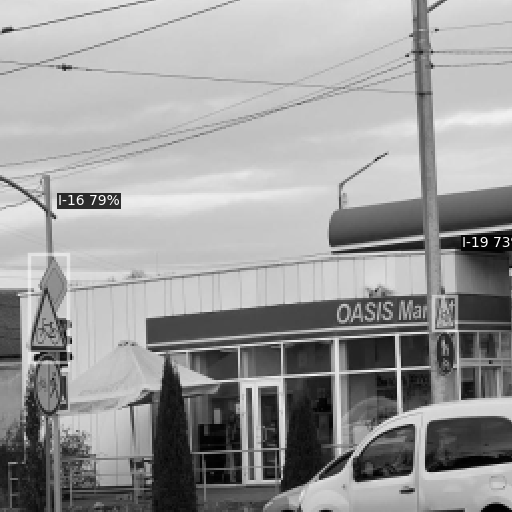

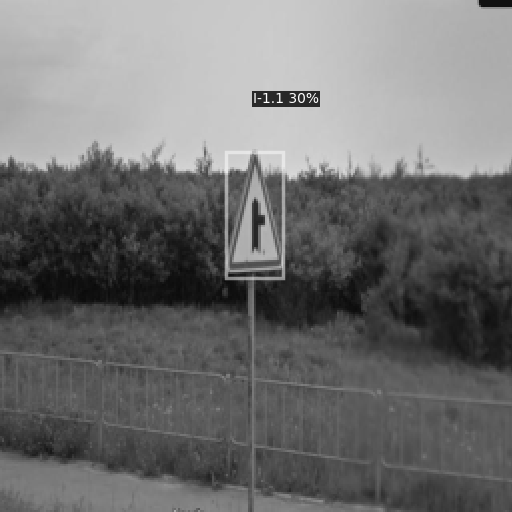

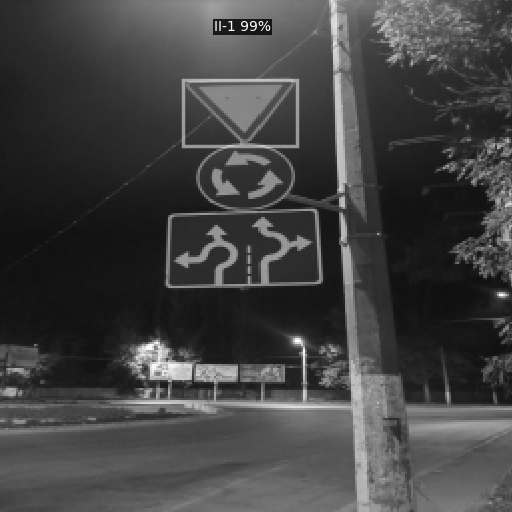

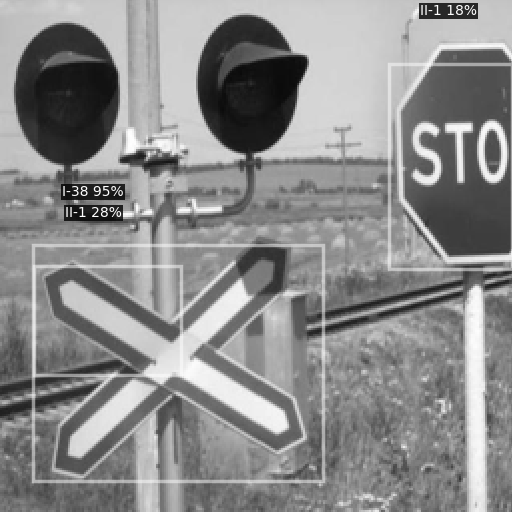

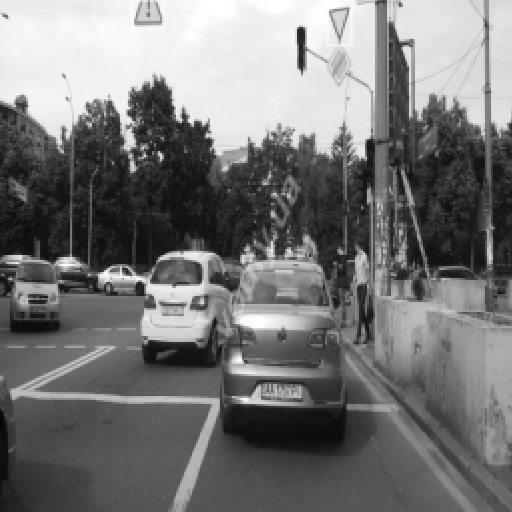

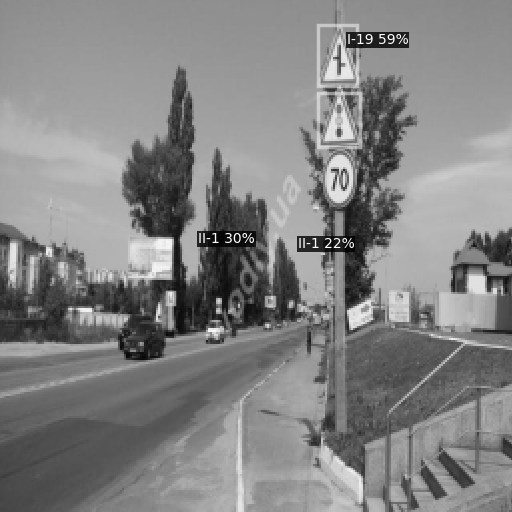

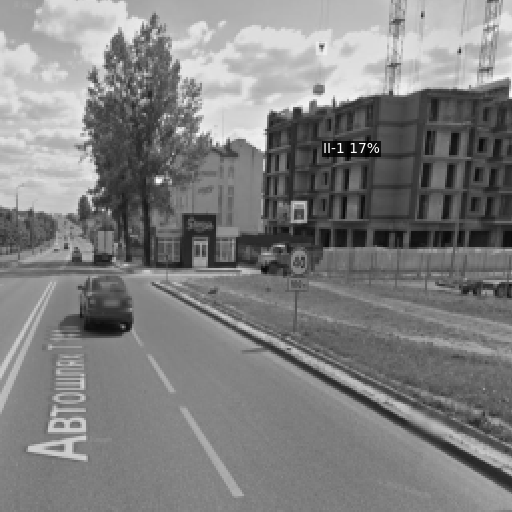

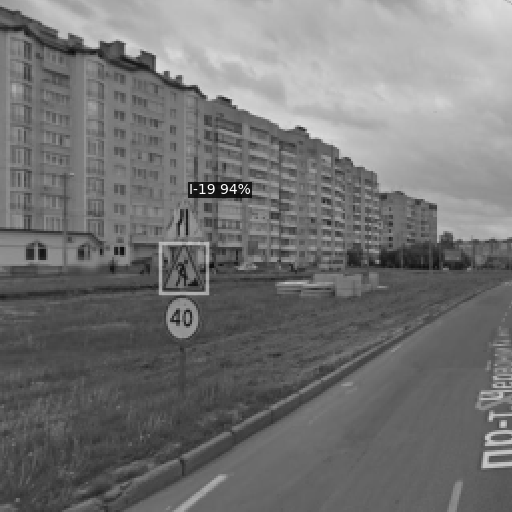

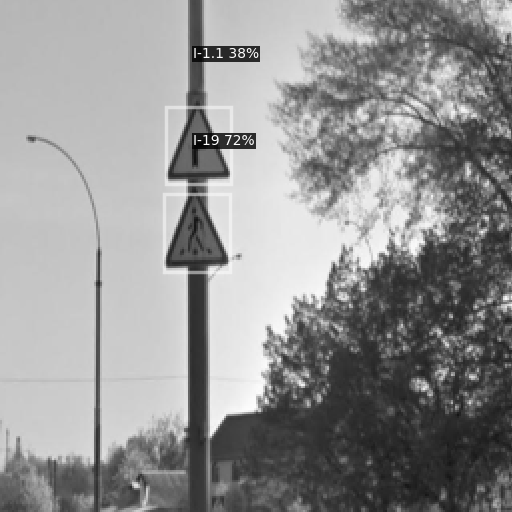

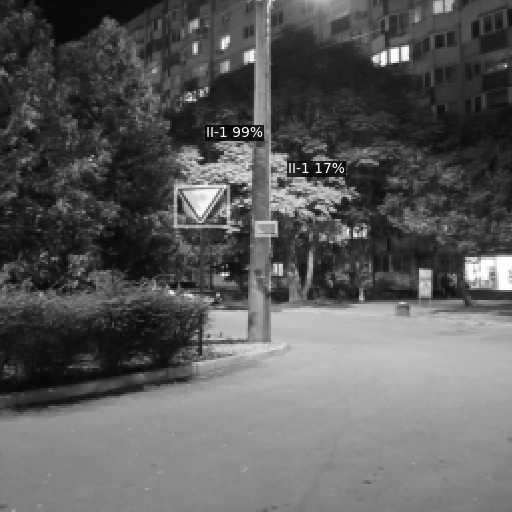

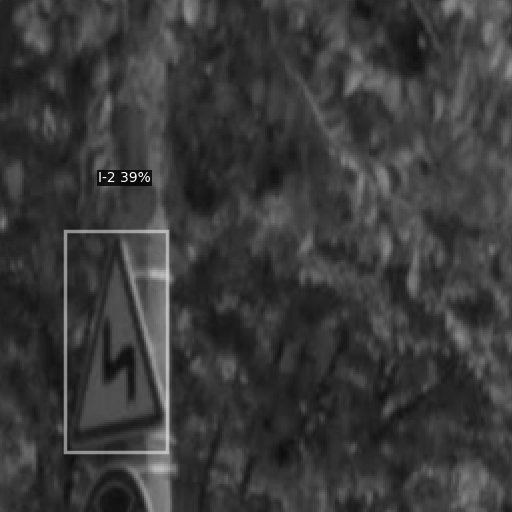

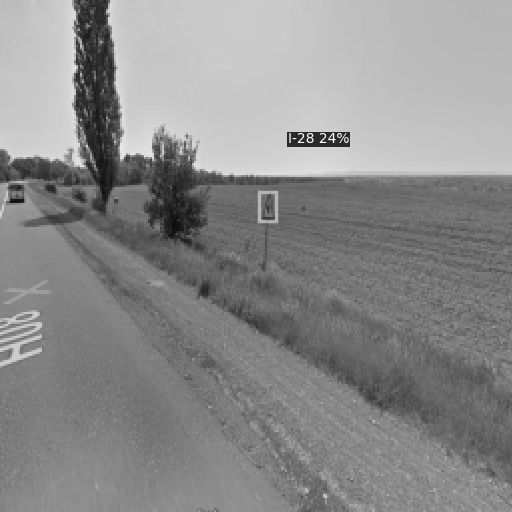

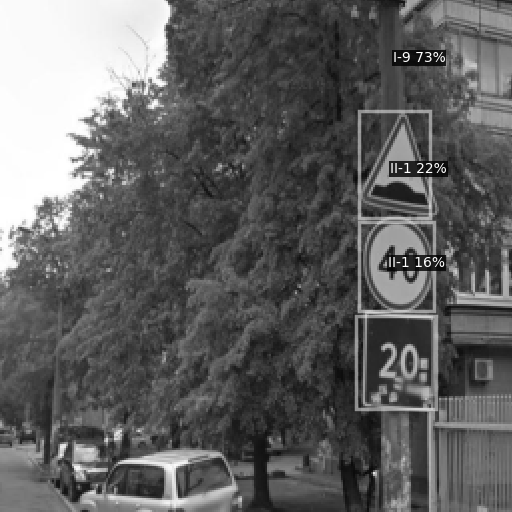

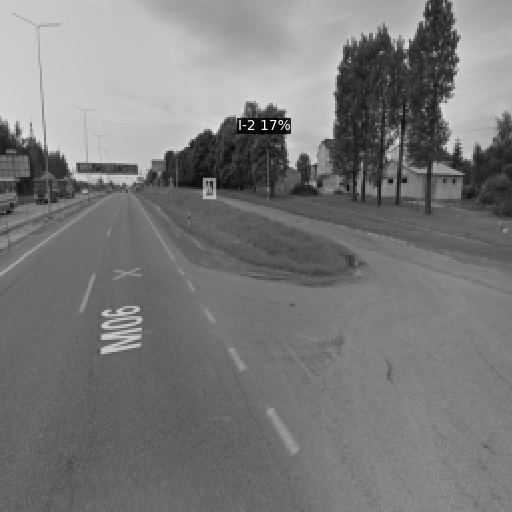

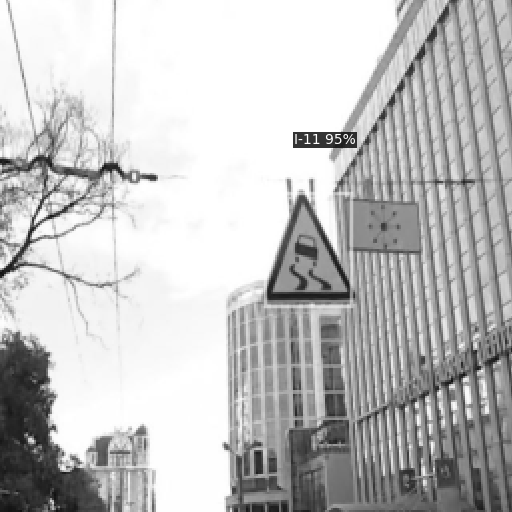

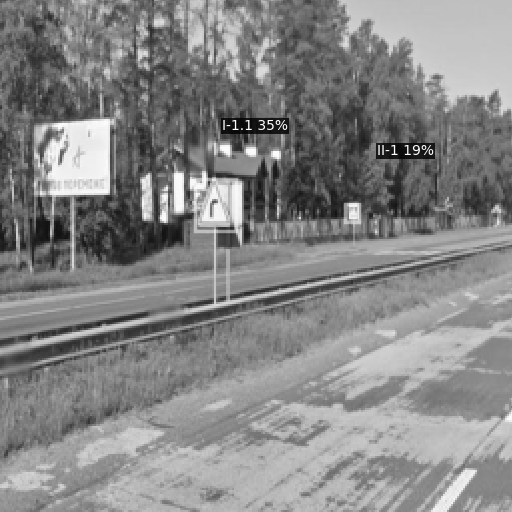

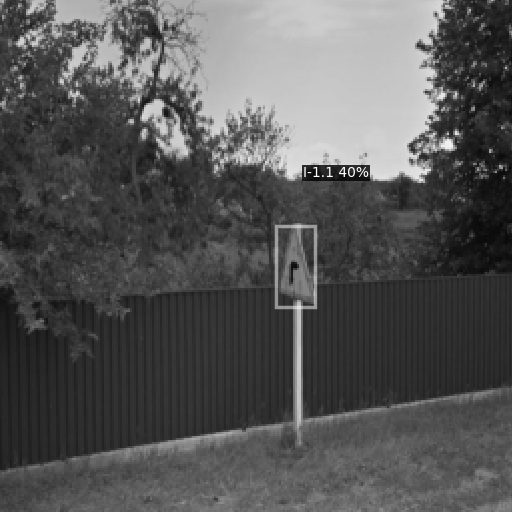

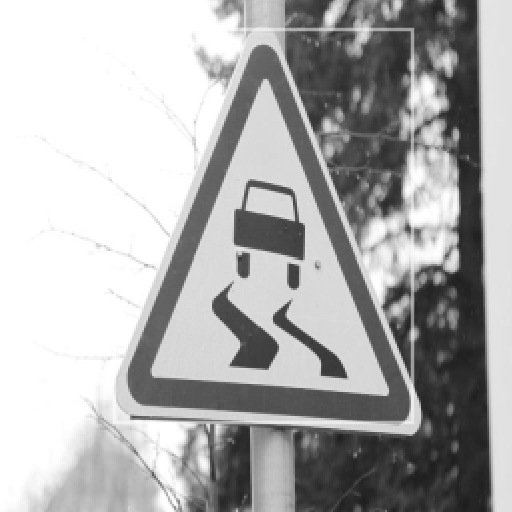

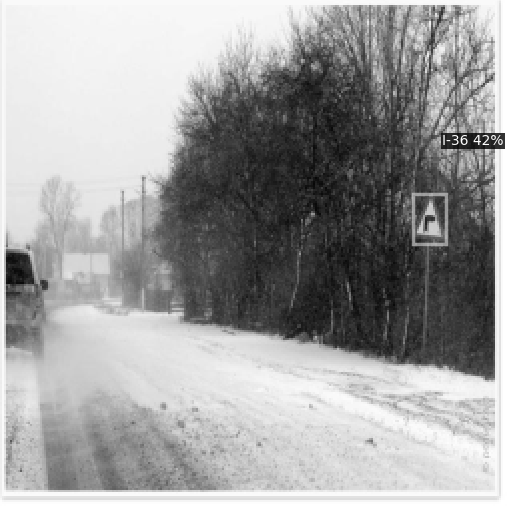

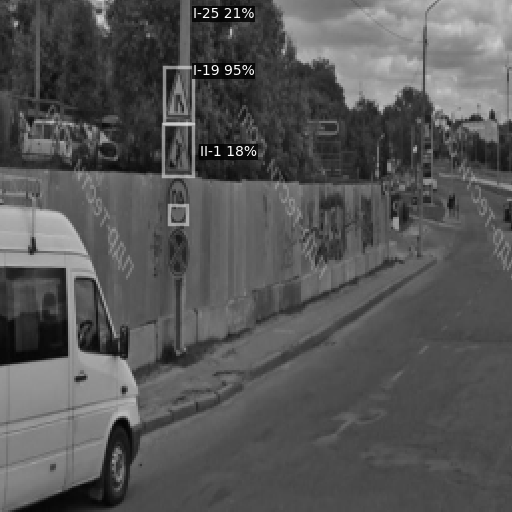

In [ ]:
from google.colab.patches import cv2_imshow
from detectron2.utils.visualizer import Visualizer, ColorMode, _create_text_labels
from detectron2.structures import Boxes, BoxMode, Instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# cfg = get_cfg()
# # cfg.MODEL.DEVICE = "cpu"
# cfg.DATASETS.TRAIN = ("my_dataset_train",)
# cfg.DATASETS.TEST = ("my_dataset_valid",)
# cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 33
cfg.MODEL.WEIGHTS = drive_path + "/model_final_VANGA_GS_5000epochs.pth"
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 33 # 168

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.15 # ignore predictions with less than 15% confidence
predictor = DefaultPredictor(cfg)

test_loader = build_detection_test_loader(cfg, "my_dataset_valid_gs")
evaluator = COCOEvaluator("my_dataset_valid_gs", cfg, False, output_dir="./output/")
metrics = inference_on_dataset(predictor.model, test_loader, evaluator)

print("Evaluation:")
print(metrics)

test_metadata = MetadataCatalog.get("my_dataset_valid_gs")
test_dataset_dicts = DatasetCatalog.get("my_dataset_valid_gs")

# Remove overlapping predictions and keep only the most confident
def non_max_suppression(boxes, scores, iou_threshold):
    indices = cv2.dnn.NMSBoxes(boxes.tolist(), scores.tolist(), score_threshold=0.0, nms_threshold=iou_threshold)
    return indices.flatten()

# Custom visualizer to prevent labels from covering the bounding box
class CustomVisualizer(Visualizer):
    def draw_instance_predictions(self, predictions):
        boxes = predictions.pred_boxes if predictions.has("pred_boxes") else None
        scores = predictions.scores if predictions.has("scores") else None
        classes = predictions.pred_classes if predictions.has("pred_classes") else None
        labels = _create_text_labels(classes, scores, self.metadata.get("thing_classes", None))
        keypoints = predictions.pred_keypoints if predictions.has("pred_keypoints") else None

        if boxes is not None:
            boxes = BoxMode.convert(boxes.tensor.cpu().numpy(), BoxMode.XYXY_ABS, BoxMode.XYXY_ABS)

        if boxes is not None:
            for box, label in zip(boxes, labels):
                color = (1.0, 1.0, 1.0)  # White color in RGBA format
                self.draw_box(box, edge_color=color)
                x, y = box[:2]
                self.draw_text(label, (x + 30, y - 30), color=color)

        return self.output

# Show the predictions for the first 20 images
for i in range(20):
    d = test_dataset_dicts[i]
    img = cv2.imread(d["file_name"])

    outputs = predictor(img)
    instances = outputs["instances"].to("cpu")
    boxes = instances.pred_boxes.tensor.numpy()
    scores = instances.scores.numpy()
    classes = instances.pred_classes.numpy()

    # If no predictions...
    if len(boxes) == 0:
        continue

    # Apply NMS
    nms_indices = non_max_suppression(boxes, scores, iou_threshold=0.5)
    filtered_boxes = boxes[nms_indices]
    filtered_scores = scores[nms_indices]
    filtered_classes = classes[nms_indices]

    new_instances = Instances(
        instances.image_size,
        pred_boxes=Boxes(filtered_boxes),
        scores=torch.tensor(filtered_scores),
        pred_classes=torch.tensor(filtered_classes)
    )

    v = CustomVisualizer(img[:, :, ::-1], metadata=test_metadata, scale=2)
    out = v.draw_instance_predictions(new_instances)
    cv2_imshow(out.get_image()[:, :, ::-1])